In [1]:
import datasets
from transformers import AutoTokenizer
import argparse
import torch.nn as nn
import torch
import timm
import torch.optim as optim
import os
import data_utils
import json
import numpy as np
import pprint
import reprogramming_model

In [2]:
text_dataset = "emotion"
vision_model_name = "vit_base_patch16_384"
cache_dir = "/data2/paarth/HuggingFaceDatasets" # UPDATE THIS TO YOUR HUGGINGFACE CACHE DIR
base_image_path = "library.jpg"
# UPDATE THE BELOW PATH TO YOUR LOCAL PATH OF THE CHECKPOINT
reprogrammer_ckpt_path = "/data2/paarth/ReprogrammingTransformers/ReprogrammingModelsRough/ds_emotion_lr_0.001_bimg_library_vm_vit_base_patch16_384_alpha_0.2_m_label_10_max/CKPTS/model_best.p"

batch_size = 4
img_size = 384
img_patch_size = 16
pert_alpha = 0.2
m_per_class = 10
label_reduction = 'max'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
dataset_configs = data_utils.text_dataset_configs
assert text_dataset in dataset_configs
text_dataset_config = dataset_configs[text_dataset]

subset = text_dataset_config['subset']
val_split = text_dataset_config['val_split']
text_key = text_dataset_config['sentence_mapping']
data_files = text_dataset_config['data_files']
dataset_name = text_dataset if data_files is None else 'json'

tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')
val_dataset_raw = datasets.load_dataset(dataset_name, subset, data_files=data_files, split=val_split, cache_dir = cache_dir)
val_dataset = val_dataset_raw.map(lambda e: tokenizer(e[text_key], truncation=True, padding='max_length'), batched=True)
val_dataset = val_dataset.map(lambda e: data_utils.label_mapper(e, text_dataset), batched=True)
val_dataset.set_format(type='torch', columns=['input_ids', 'label'])

val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

Using custom data configuration default
Reusing dataset emotion (/data2/paarth/HuggingFaceDatasets/emotion/default/0.0.0/5276a3f9a2c014ee528f5cca7ad34f185b886acd0f60fe18c61c6768662ca828)


In [4]:
def load_checkpoint(checkpoint_path, model):
    assert os.path.isfile(checkpoint_path)
    print("Loading checkpoint '{}'".format(checkpoint_path))
    checkpoint_dict = torch.load(checkpoint_path, map_location='cpu')
    model.load_state_dict(checkpoint_dict['state_dict'])
    iteration = checkpoint_dict['iteration']

    image_net_labels = None
    if 'image_net_labels' in checkpoint_dict:
        image_net_labels = checkpoint_dict['image_net_labels']

    print("Loaded checkpoint '{}' from iteration {}" .format(
        checkpoint_path, iteration))
    return model, iteration, image_net_labels

vocab_size = len(tokenizer.get_vocab())

img_mean = data_utils.image_model_configs[vision_model_name]['mean']
img_std = data_utils.image_model_configs[vision_model_name]['std']

n_classes = text_dataset_config['num_labels']


reprogrammer = reprogramming_model.ReprogrammingFuntion(vocab_size, img_patch_size, 
    img_size, 
    img_path = base_image_path, alpha = pert_alpha, img_mean = img_mean, img_std = img_std)
reprogrammer.to(device)


reprogrammer, _, image_net_labels = load_checkpoint(reprogrammer_ckpt_path, reprogrammer)

/home/paarth/TIMM/reprogramming_model.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.base_image = torch.tensor(image, requires_grad=False).to(device)


Loading checkpoint '/data2/paarth/ReprogrammingTransformers/ReprogrammingModelsRough/ds_emotion_lr_0.001_bimg_library_vm_vit_base_patch16_384_alpha_0.2_m_label_10_max/CKPTS/model_best.p'
Loaded checkpoint '/data2/paarth/ReprogrammingTransformers/ReprogrammingModelsRough/ds_emotion_lr_0.001_bimg_library_vm_vit_base_patch16_384_alpha_0.2_m_label_10_max/CKPTS/model_best.p' from iteration 199500


In [5]:
vision_model = timm.create_model(vision_model_name, pretrained=True)
vision_model.eval()
vision_model.to(device)

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): ModuleList(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU()
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
    )
    (1): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (

In [6]:
# Helper functions for mapping labels between image and text classes

def get_mapped_logits(logits, class_mapping):
    """
    logits : Tensor of shape (batch_size, 1000) # imagenet class logits
    class_mapping: class_mapping[i] = list of image net labels for text class i
    reduction : max or mean
    """
    reduction = label_reduction
    mapped_logits = []
    for class_no in range(len(class_mapping)):
        if reduction == "max":
            class_logits, _ = torch.max(logits[:,class_mapping[class_no]], dim = 1) # batch size
        elif reduction == "mean":
            class_logits = torch.mean(logits[:,class_mapping[class_no]], dim = 1) # batch size
        else:
            raise NotImplentedException()

        mapped_logits.append(class_logits)
    return torch.stack(mapped_logits, dim = 1)

def create_label_mapping(n_classes, m_per_class, image_net_labels = None):
    """
    n_classes: No. of classes in text dataset
    m_per_class: Number of imagenet labels to be mapped to each text class
    """
    if image_net_labels is None:
        image_net_labels = range(1000)

    class_mapping = [[] for i in range(n_classes)]

    idx = 0
    for _m in range(m_per_class):
        for _class_no in range(n_classes):
            class_mapping[_class_no].append(image_net_labels[idx])
            idx += 1
    return class_mapping



### For displaying numpy array as image - H X W X C numpy array - expects 0 to 255 pixel values

In [7]:
import PIL.Image
from io import BytesIO
import IPython.display
import numpy as np
def showarray(a, fmt='png'):
    a = np.uint8(a)
    f = BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    IPython.display.display(IPython.display.Image(data=f.getvalue()))

/home/paarth/TIMM/envtimm/lib/python3.6/site-packages/datasets/arrow_dataset.py:847: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.tensor(x, **format_kwargs)


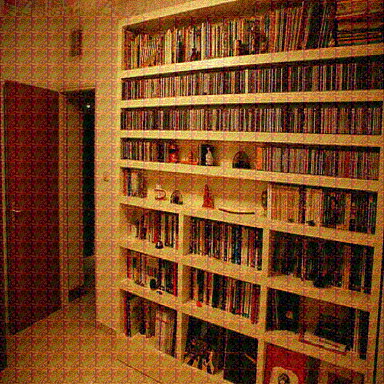

tensor(4, device='cuda:0')


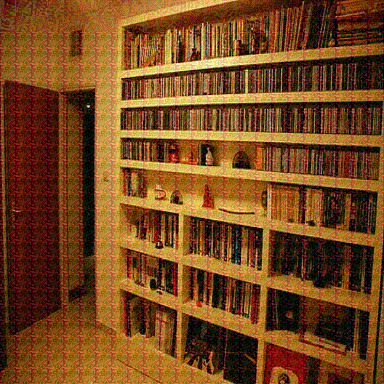

tensor(3, device='cuda:0')


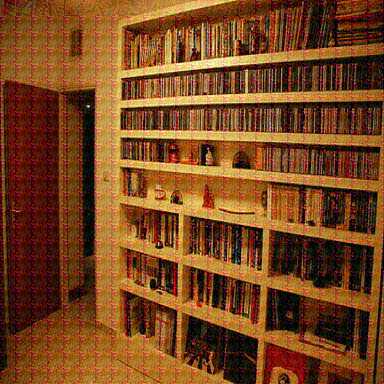

tensor(2, device='cuda:0')


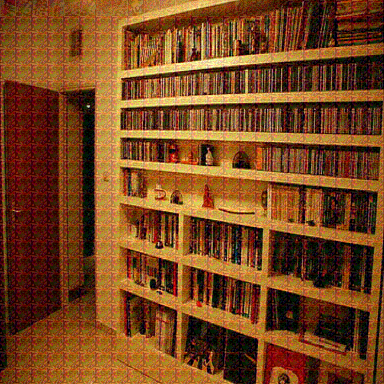

tensor(3, device='cuda:0')


In [8]:
class_mapping = create_label_mapping(n_classes, m_per_class, image_net_labels)
for bidx, batch in enumerate(val_loader):
    sentence = batch['input_ids'].to(device)
    labels = batch['label'].to(device)
    programmed_img = reprogrammer(sentence)
    unnormalized_img = reprogrammer.unnormalize_image(programmed_img)
    unnormalized_img_np = unnormalized_img[0].permute(1, 2, 0).cpu().detach().numpy() * 255.0
    showarray(unnormalized_img_np)
    
    logits = vision_model(programmed_img)
    mapped_logits = get_mapped_logits(logits, class_mapping)
    prediction = torch.argmax(mapped_logits, dim = 1)
    correct = torch.sum(prediction == labels)
    print(correct)
    
    
    if bidx > 2:
        break
    